<script async src="https://www.googletagmanager.com/gtag/js?id=UA-59152712-8"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-59152712-8');
</script>

# Removing `if` Statements from Expressions 

## Author: Patrick Nelson
### Formatting improvements courtesy Brandon Clark

Conditional statements are a critical tool in programming, allowing us to control the flow through a program to avoid pitfalls, code piecewise-defined functions, and so forth. However, there are times when it is useful to work around them. It takes a processor time to evaluate the whether or not to execute the code block, so for some expressions, performance can be improved by rewriting the expression to use an absolute value function in a manner upon which we will expand in this tutorial. Even more relevant to NRPy+ are piecewise-defined functions. These inherently involve `if` statements, but NRPy+'s automatic code generation cannot handle these by itself, requiring hand-coding to be done. However, if it is possible to rewrite the expression in terms of absolute values, then NRPy+ can handle the entire thing itself. 

The absolute value is a function that simply returns the magnitude of its argument, a positive value. This is, 
\begin{align}
|x|&= \left \{ \begin{array}{lll}x & \mbox{if} & x \geq 0 \\
-x & \mbox{if} & x \leq 0 \end{array} \right. \\
\end{align}

In C, this is implemented as `fabs()`, which merely has to check that the first bit of a double-precision floating point number is 0, and is thus quite fast. 

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$

This notebook is organized as follows

0. [Step 0](#prelim): Preliminaries
1. [Step 1](#min_max): Minimum and Maximum
1. [Step 2](#piecewise): Piecewise-defined functions
1. [Step 3](#latex_pdf_output): Output this notebook to $\LaTeX$-formatted PDF file

<a id='prelim'></a>

# Step 0: Preliminaries \[Back to [top](#toc)\]
$$\label{prelim}$$

We will start by importing the Python modules we want to use. For demonstration purposes, we will use `np.absolute()` and floating point numbers. In practice, we will want to use `nrpyAbs()` and *not* `sp.Abs()` with our symbolic expressions, which will force `outputC` to use the C function `fabs()`, and not try to multiply the argument by its complex conjugate and then take the square root.

We will also show a plot of $y=|x|$ and $y=x$ for the sake of completeness. 

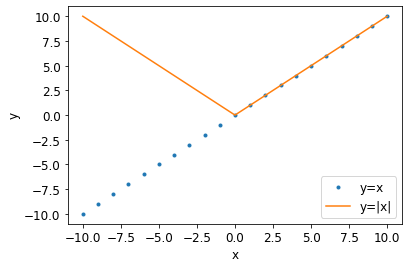

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

x_data = np.arange(start = -10.0, stop = 11.0, step = 1.0)
y_data = np.absolute(x_data)
plt.figure()
a = plt.plot(x_data,x_data,'.',label="y=x")
b = plt.plot(x_data,y_data,label="y=|x|")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()


<a id='min_max'></a>

# Step 1: Minimum and Maximum \[Back to [top](#toc)\]
$$\label{min_max}$$

Our first job will be to rewrite minimum and maximum functions without if statements. For example, the typical implementation of `min(a,b)` will be something like this:
```python
def min(a,b):
    if a<b:
        return a
    else:
        return b
```
However, to take full advantage of NRPy+'s automated function generation capabilities, we want to write this without the `if` statements, replacing them with calls to `fabs()`. We will define these functions in the following way: 
\begin{align}
\min(a,b) &= \tfrac{1}{2} \left( a+b - \lvert a-b \rvert \right) \\
\max(a,b) &= \tfrac{1}{2} \left( a+b + \lvert a-b \rvert \right). \\
\end{align}
For real numbers, these operate exactly as expected. In the case $a>b$,
\begin{align}
\min(a,b) &= \tfrac{1}{2} \left( a+b - (a-b) \right) = b \\
\max(a,b) &= \tfrac{1}{2} \left( a+b + (a-b) \right) = a, \\
\end{align}
and in the case $a<b$, the reverse holds:
\begin{align}
\min(a,b) &= \tfrac{1}{2} \left( a+b - (b-a) \right) = a \\
\max(a,b) &= \tfrac{1}{2} \left( a+b + (b-a) \right) = b, \\
\end{align}

In code, we will represent this as:
```
min_noif(a,b) = sp.Rational(1,2)*(a+b-nrpyAbs(a-b))
max_noif(a,b) = sp.Rational(1,2)*(a+b+nrpyAbs(a-b))
```


In [4]:
# First, we'll write the functions. Note that we are not using sympy right now. For NRPy+ code generation, 
# use the expressions above. 
def min_noif(a,b):
    return 0.5 * (a+b-np.absolute(a-b))

def max_noif(a,b):
    return 0.5 * (a+b+np.absolute(a-b))

# Now, let's put these through their paces. 
a_number = 5.0
another_number = 10.0
print("The minimum of "+str(a_number)+" and "+str(another_number)+" is "+str(min_noif(a_number,another_number)))

The minimum of 5.0 and 10.0 is 5.0


Feel free to test other cases above if you'd like. Note that we use a suffic, `_noif`, to avoid conflicts with other functions. When using this in NRPy+, make sure you use `sp.Rational()` and the `nrpyAbs()` function, which will always be interpreted as the C function `fabs()` (Sympy's `sp.Abs()` may get interpreted as $\sqrt{zz^*}$, for instance).


<a id='piecewise'></a>

# Step 3: Piecewise-defined functions \[Back to [top](#toc)\]
$$\label{piecewise}$$

Next, we'll define functions to represent branches of a piecewise-defined function. For example, consider the function 
\begin{align}
|x|&= \left \{ \begin{array}{lll} x^2+1 & \mbox{if} & x \leq 0 \\
\exp(x) & \mbox{if} & x \geq 0 \end{array} \right. , \\
\end{align}
which function continuous, but not differentiable at $x=0$. The functions we'll write will have poorly defined behavior at their interfaces if the function is not continuous. 

To solve this problem, let's add the two parts together, multiplying each part by a function that is either one or zero depending on $x$. To define $x \leq 0$, this can be done by multiplying by the minimum of $x$ and $0$. We also will need to normalize this. To avoid putting a zero in the denominator, however, we will instead take the minimum of $x$ and some small $\epsilon$ in the denominator, i.e.,
$$
\frac{\min(x,0)}{\min(x,\epsilon)}
$$
This $\epsilon$ corresponds to `TINYDOUBLE` in NRPy+; so, we will follow suit in our code and define such a variable with its typical value, `1e-100`. 

The corresponding expression for $x \geq 0$ can be written as 
$$
\frac{\max(x,0)}{\max(x,\epsilon)}
$$
When using these for numerical relativity codes, it is important to consider the relationship between $\epsilon$, or `TINYDOUBLE`, and the gridpoints in the simulation. Care must be taken to ensure that at no point does $x = -\epsilon$ to avoid division by zero. 
**TODO: Check this. Is this actually a problem?**

So, we'll code NumPy versions of these expressions below. 

In [5]:
TINYDOUBLE = 1.0e-100
def coord_leq(x): 
    return min_noif(x,0)/min_noif(x,TINYDOUBLE)
def coord_geq(x): 
    return max_noif(x,0)/max_noif(x,TINYDOUBLE)

# Now, define our the equation and plot it. 
y_data = coord_leq(x_data)*(x_data**2+1)\
        +coord_geq(x_data)*np.exp(x_data)

<ipython-input-5-378d0c247974>:3: RuntimeWarning: invalid value encountered in true_divide
  return min_noif(x,0)/min_noif(x,TINYDOUBLE)
<ipython-input-5-378d0c247974>:5: RuntimeWarning: invalid value encountered in true_divide
  return max_noif(x,0)/max_noif(x,TINYDOUBLE)
